In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import sys
sys.path.append('/content/drive/MyDrive/deliverables/code/helper') #update path needed

In [21]:
import pandas as pd
import numpy as np
from fixed_effect import HolidayDataProcessor, SalesDataProcessor
from data_prep import CreditDataProcessor
from train_test import DataSplitter, NewModel
from anomaly_detection import AnomalyDetection
import warnings

# To suppress all warnings (not recommended)
warnings.filterwarnings("ignore")

In [22]:
holidays_df = HolidayDataProcessor(2016, 2023).get_holidays_dataframe()
sales_df = SalesDataProcessor(2016, 2023).get_sales_df()

In [23]:
file_path = "/content/drive/MyDrive/deliverables/code/data/data4columbia_credit.csv" #update path needed
company_code = "22328d65a8ae"
train_ratio = 0.8

data_processor = CreditDataProcessor(file_path, train_ratio)
data_processor.load_data()
data_processor.get_company_data(company_code)
main_df = data_processor.add_seasonality()

In [24]:
merged_df = main_df.join(sales_df, how="left")
merged_df = merged_df.join(holidays_df, how='left')
merged_df["holiday"] = merged_df["holiday"].apply(lambda x: 1 if pd.notnull(x) else 0)
merged_df["events"] = merged_df["events"].apply(lambda x: 1 if pd.notnull(x) else 0)

In [25]:
train_data, test_data = DataSplitter(merged_df, train_ratio).split_data()

In [26]:
init_model = NewModel(train_data, period=30, seasonal=7, independent_cols=['holiday', 'events'], dependent_col='trend')
init_model.get_trend()
init_model.train_linear_regression_model()
test_data = init_model.predict(test_data.copy())

mse = init_model.calculate_mean_squared_error(test_data["actual"], test_data["prediction"])
print("Mean Squared Error:", mse)

Mean Squared Error: 7901.96909163711


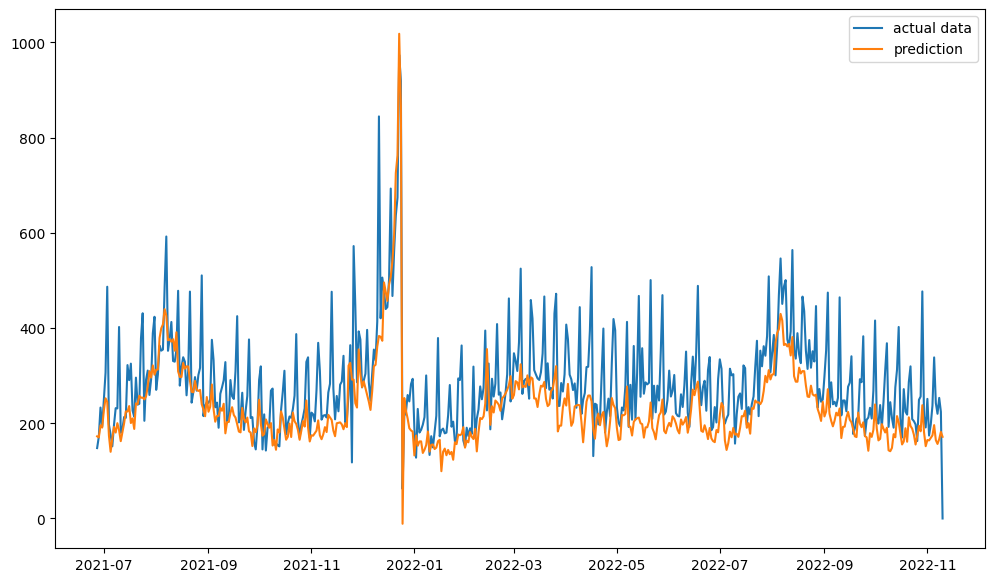

In [27]:
init_model.plot_results(test_data)

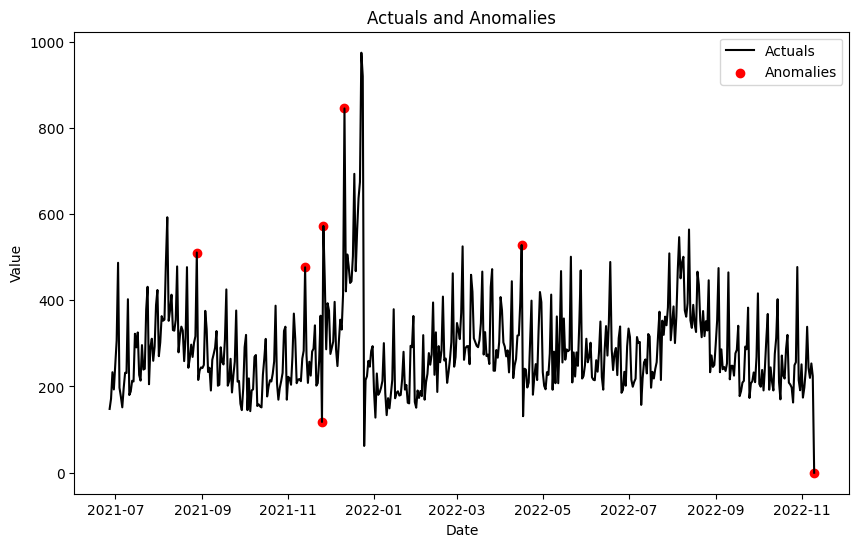

In [28]:
anomaly = AnomalyDetection(test_data.set_index("ds"))
anomaly.detect_anomalies()
anomaly.plot_anomalies()